# Arrival Time Prediction - Synchronisation
This notebook is the third on the work on GP regression for arrival time prediction. The goal of this one is to estimate a function for each segment that synchonises the progress of all trajectories. This needs to be done so that predictions can be made based on a new trajectory and not a single data point.

The synchonisation function will be estimated using a GP, which we are all familiar now by now. First off, let's get some libraries into scope, set the seed and load the data that was pickled in the first notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats 
import math
import tensorflow as tf
import plot
import GPy
import gp_gpy as gp
import synch

train = pd.read_pickle('train.pkl')
support = pd.read_pickle('support.pkl')
route_n = 3
traj_n = 7
sns.set(style="darkgrid")
np.random.seed(1)

## Hyperparameter Priors
The synchronisation function is a function $f : \mathcal{R}^2 \mapsto [0, 1]$ so we will use a bivariate GP model. Let's look at some priors for the hyperparameters kernel lengthscale, kernel variance and likelihood variance.

### Kernel Lenghtscale ($l$)
When the data was downsampled in the pre processing, it was done with $\delta = 3*10^{-2}$. Based on this we have implicitly said that points that have a distance of delta are close by, so the lengthscale prior should reflect that.

Since GPFlow is quite a minimalistic library (that is: a bit buggy, and poorly documented), there is no way of plotting kernel functions, and the function to compute covariance matrices at all, `k.compute_K`, seem to be busted beyond belief. Plotting will have to be done by implementing the function by oneself and using it for plotting. Thus you find an implementation of the RBF kernel function below. 

The goal is to find an $l$ of the RBF that makes it wide enough to consider points within delta distance as close. Trying some different values shows that $l = 0.25$ gives something that would consider the closest $10$ points close and then decay noticeably.

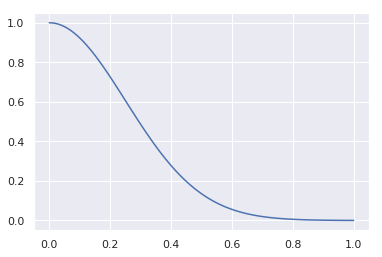

In [2]:
def rbf(X, x, var, l):
      return var*np.exp(-(abs(X-x)*abs(X-x))/(2*math.pow(l, 2)))

xmin = 0
xmax = 1
xx = np.linspace(xmin, xmax, 100)[:,None]
sns.lineplot(x=xx[:,0], y = rbf(xx, 0, 1, 0.25)[:,0])

Having concluded a value of $l$ that makes sense, we now put a distribution over it with mean around the chosen value and a variance representing our certainty. I am not too certain in my belief, and believe that $l$ could take on values quite a bit bigger than the mean value. Since the length scale is strictly positive I've chosen a gamma distribution, which it can be seen in the plot below. This is our length scale prior!

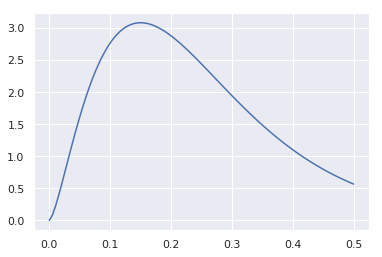

In [3]:
xmin = 0
xmax = 0.5
l_alpha = 2.5
l_theta = 0.1
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=l_alpha, scale=l_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Kernel Variance ($\sigma_f$)
The kernel variance determines the average distance that the function output has from the function mean. Since the output of the function is on $[0, 1]$, the output should not need to vary more than this. To prevent overfitting a $\sigma_f = 0.6$ seems right, but let's go with quite high uncertainty on this one. Since it is also a strictly positive quantity a gamma distribution is used here as well, like with the lengthscale.

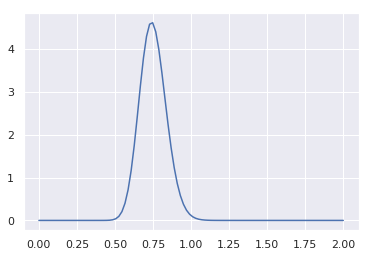

In [4]:
xmin = 0
xmax = 2
sigmaf_alpha = 75
sigmaf_theta = 0.01
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigmaf_alpha, scale=sigmaf_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Likelihood Variance ($\sigma$)
We also need to chose a prior for the likelihood variance $\sigma$, which representas the measurement noise. This model will assume a static variance, even though we know that it depends on where in the city you are. In mode dense areas the GPS accuracy suffers a bit while it works well in more rural areas. A seperate model for the GPS variance estimation should be used if this was done properly.

In the provided thesis the average GPS variance of a smartphone is claimed to be $\sigma = 10^-5$ so we'll go with that, but like with $\sigma_f$ we will be quite uncertain.

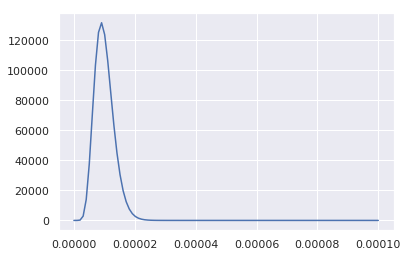

In [5]:
xmin = 0
xmax = 0.0001
sigma_alpha = 10
sigma_theta = 0.000001
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigma_alpha, scale=sigma_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

In [6]:
d_lat = train.lat.max() - train.lat.min()
d_lon = train.lon.max() - train.lon.min()
print(d_lat, d_lon)


0.04714202880859908 0.009422302246100855


# Training
Alrighty, time to train a GP. The idea here is to train on a single trajectory that embodies what we want from the synchronisation. This works because the model is used to interpolation and has consequently no need to generalise. We use both the training and support data for this model, for reasons mentioned in notebook 1.

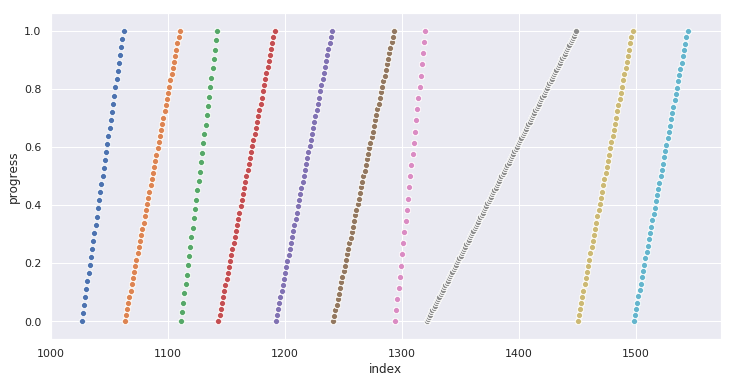

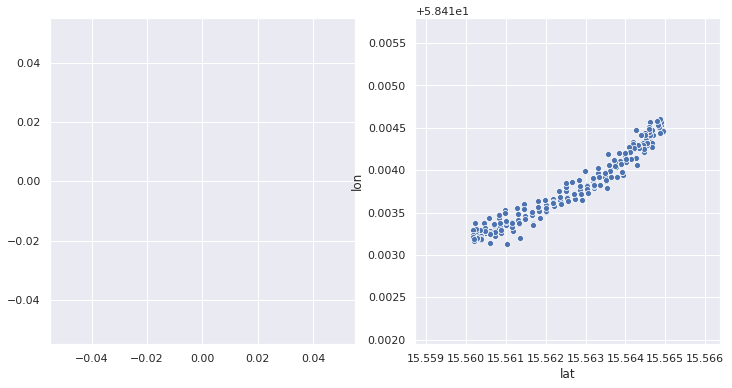

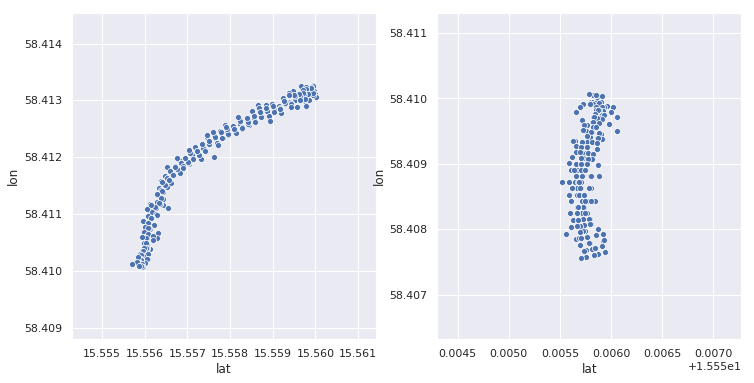

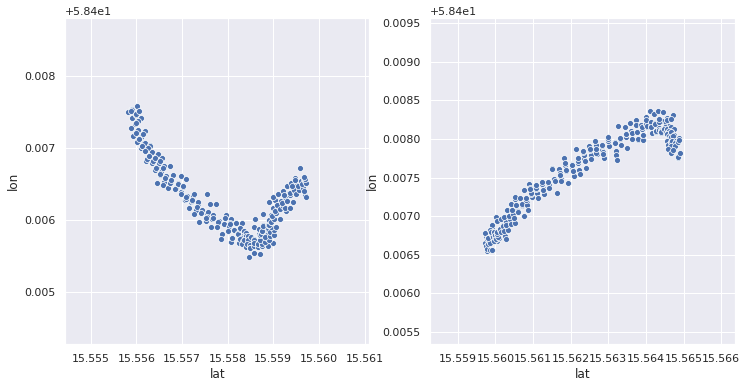

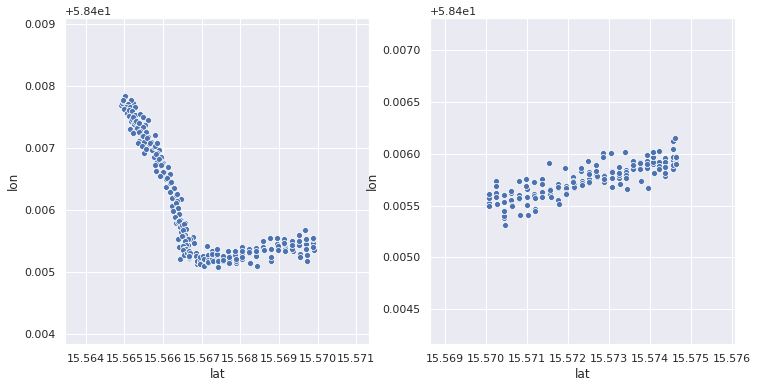

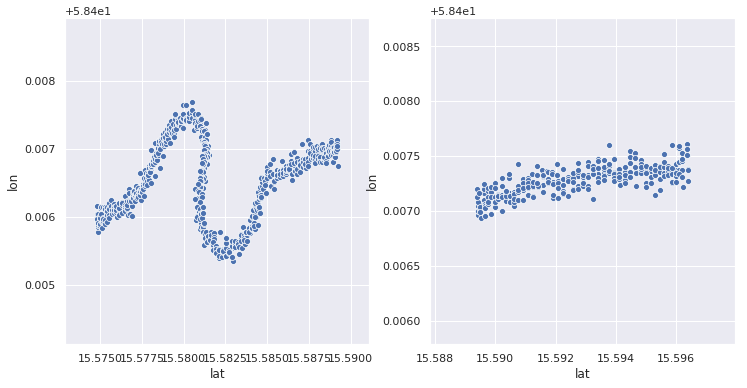

In [7]:
n_trajs = train.traj.unique()
traj_n = n_trajs[1]
traj = train[train.traj == traj_n]
traj_support = support[support.traj == traj_n]
train_traj = traj.append(traj_support)
plot.traj_progress(train_traj)
plot.traj_segment_grid(train_traj, 'lat', 'lon')

Having found a seg_n that seems typical we can now fit GPs for each of its segments.

In [8]:
def train_gp(data, route_n, traj_n, seg_n):
    seg = data[data.seg == seg_n]
    #print(seg)
    d_lat = train.lat.max() - train.lat.min()
    d_lon = train.lon.max() - train.lon.min()
    model = gp.build_synch(seg, ['lat', 'lon'], ['progress'], route_n, seg_n)
    model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.1))
    model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.01))
    model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.1))
    gp.train(model, 5)
    return model

np.random.seed(2)
n_segs = traj.seg.unique()
gps = {seg_n: train_gp(train_traj, route_n, traj_n, seg_n) for seg_n in n_segs}

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -603.5783007397471
Optimization restart 2/5, f = -603.5783007345344
Optimization restart 3/5, f = -603.5783007397538


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -603.5783007098349
Optimization restart 5/5, f = -603.5783007398061
Optimization restart 1/5, f = -817.8431734715804
Optimization restart 2/5, f = -817.8431734713176
Optimization restart 3/5, f = -817.843173471787


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -817.8431734715721
Optimization restart 5/5, f = -817.8431734691642
Optimization restart 1/5, f = -489.08883678552723
Optimization restart 2/5, f = -489.08883678551354
Optimization restart 3/5, f = -489.0888367855345
Optimization restart 4/5, f = -489.088836785217


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -489.0888367855457
Optimization restart 1/5, f = -1018.7888705735187
Optimization restart 2/5, f = -1024.1887770814176
Optimization restart 3/5, f = -1018.7888705892267
Optimization restart 4/5, f = -1024.188777060118


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -1018.7888705904793
Optimization restart 1/5, f = -867.7776837656586
Optimization restart 2/5, f = -867.7776837658473
Optimization restart 3/5, f = -867.7776837623383
Optimization restart 4/5, f = -867.7776837657359
Optimization restart 5/5, f = -867.7776837656468


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -986.1003668136931
Optimization restart 2/5, f = -986.3336809176182
Optimization restart 3/5, f = -986.3336809108544
Optimization restart 4/5, f = -986.1003668596892


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -986.3336809151359
Optimization restart 1/5, f = -644.4357839307527
Optimization restart 2/5, f = -644.435783932937
Optimization restart 3/5, f = -644.4357839312067
Optimization restart 4/5, f = -644.4357839320533
Optimization restart 5/5, f = -644.4357839268811


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -3411.0053828247487
Optimization restart 2/5, f = -919.7627587058607
Optimization restart 3/5, f = -3411.0053828289874
Optimization restart 4/5, f = -3411.0053826418775


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -3411.0053828114937
Optimization restart 1/5, f = -967.6985961489207
Optimization restart 2/5, f = -967.6985961484147
Optimization restart 3/5, f = -967.6985961487576


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -967.698596148754
Optimization restart 5/5, f = -967.6985961486313
Optimization restart 1/5, f = -958.8649429563201
Optimization restart 2/5, f = -965.3439706313359
Optimization restart 3/5, f = -935.793858590599
Optimization restart 4/5, f = -965.3439706309964
Optimization restart 5/5, f = -958.8649429560118


 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not 

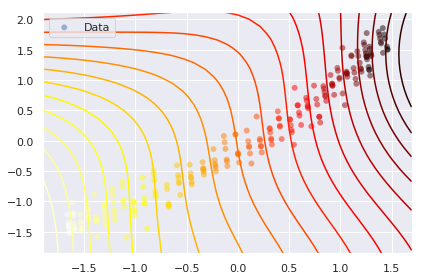

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


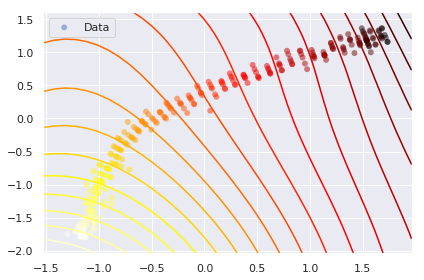

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


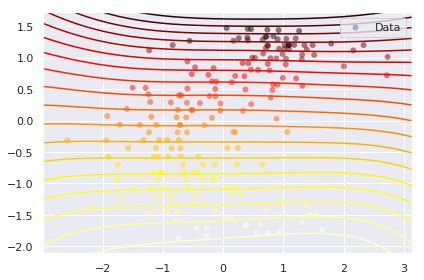

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


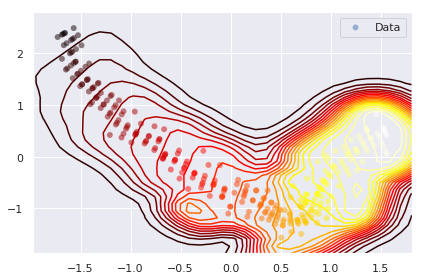

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


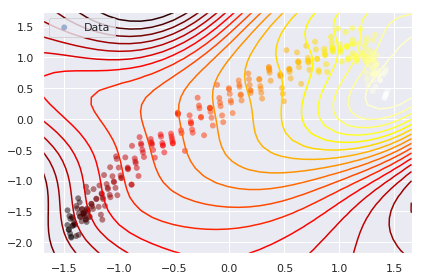

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


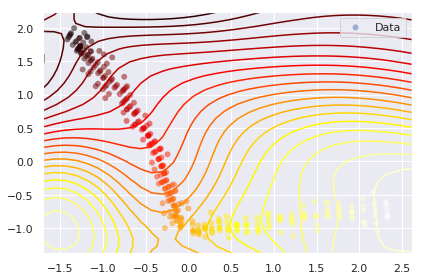

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


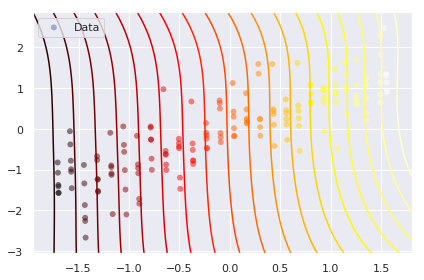

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


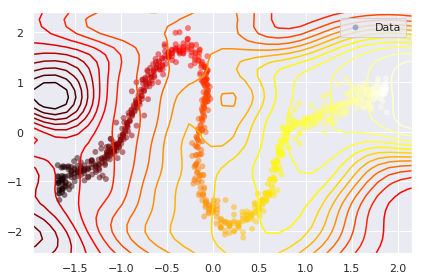

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


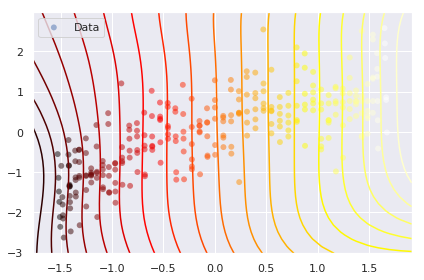

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


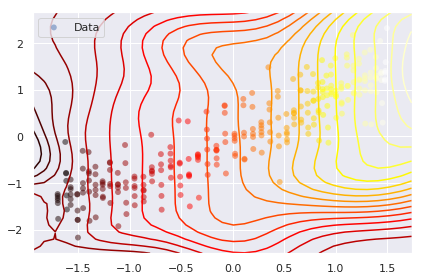

In [9]:
for model in gps.values():
    gp.plot(model)

Using the support data together with stop compression has given amazing results and the synchronisation is a success. Below is a plot of the synchronisation of some unseen new trajectories to test its robustness.

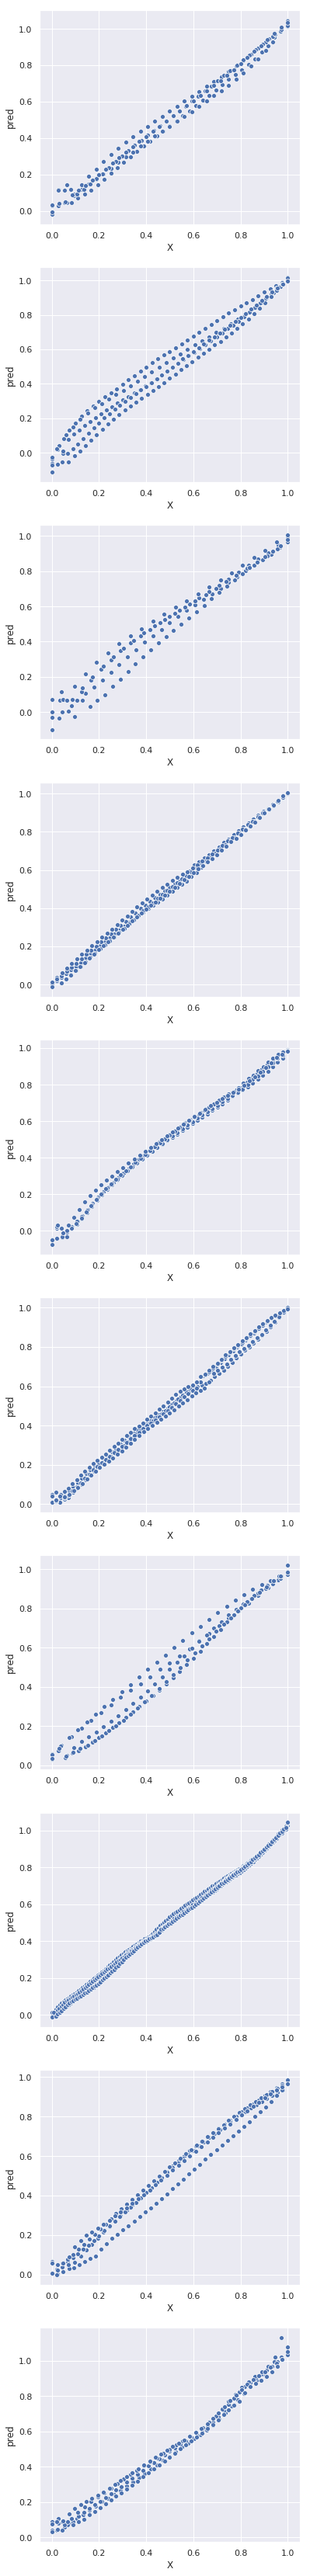

In [10]:
def synch_data(synch_gp, data):
    latlon  = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(xy, axis=1)
    return synched_data

test = pd.read_pickle('test.pkl')
test_traj_n = test.traj.unique()[0]
test_traj = [test.traj == test_traj_n]

_fig, ax = plt.subplots(nrows=len(n_segs), ncols=1, figsize=(6, int(6*len(n_segs))))
for i, seg_n in zip(range(len(n_segs)), n_segs):
    seg = test[test.seg == seg_n]
    X = seg[['lat', 'lon']].values
    tau, _var = gp.predict(gps[int(seg_n)], X)
    df = pd.DataFrame({'pred': tau.T[0], 'X': seg.progress})
    sns.scatterplot(data=df, x='X', y='pred', ax=ax[i])
        
#plot.traj_segment_grid(test, 'progress', 'tau')
    


We see that the synchronisation is quite robust, and so we save the trajectories.

In [11]:
for model in gps.values():
     gp.save(model)

A final test of the load functions and plotting of (training) predictions

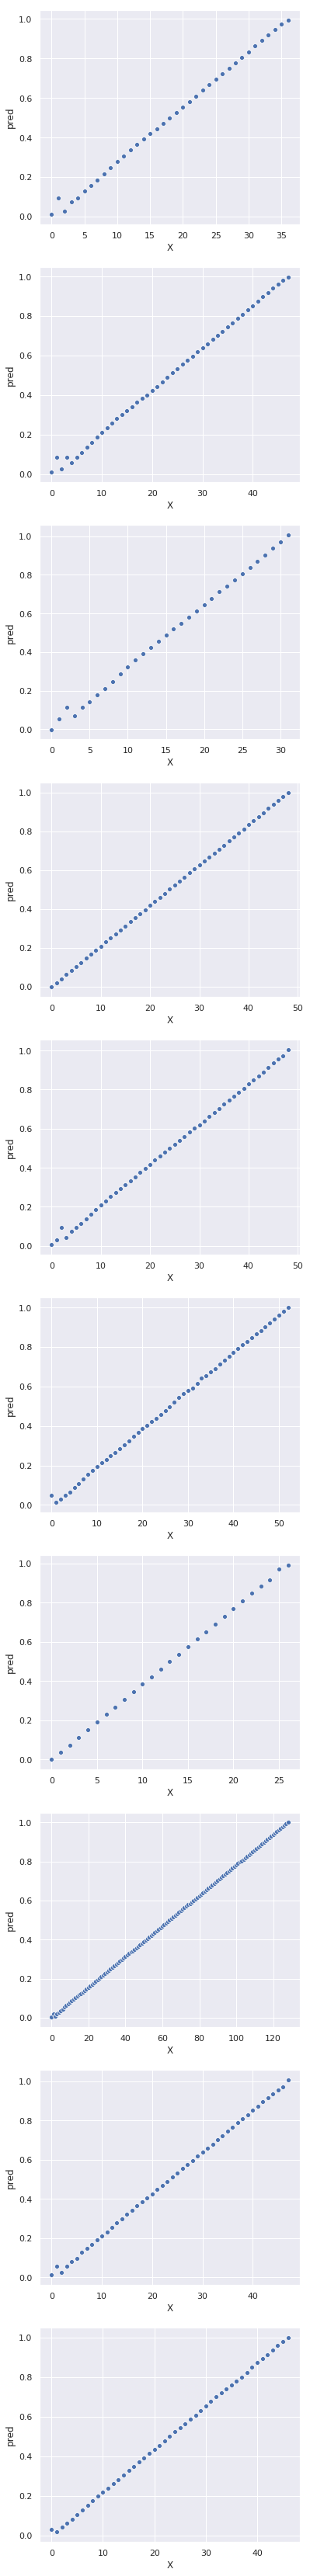

In [12]:
from sklearn.preprocessing import scale

_fig, ax = plt.subplots(nrows=len(n_segs), ncols=1, figsize=(6, int(6*len(n_segs))))
for i, seg_n in zip(range(len(n_segs)), n_segs):
    seg = traj[traj.seg == seg_n]
    sgp = gp.load_synch(route_n, seg_n)
    X = scale(seg[['lat', 'lon']].values)
    mean, _var = gp.predict(sgp, X)
    df = pd.DataFrame({'pred': mean.T[0], 'X': range(X.shape[0])})
    sns.scatterplot(data=df, x='X', y='pred', ax=ax[i])